In [11]:
from pathlib import Path
from shapely.geometry import Polygon

import geopandas as gpd
import huracanpy
import numpy as np
import pandas as pd
from parse import parse
from tqdm import tqdm
import xarray as xr

In [12]:
japan = pd.read_csv("~/john/Areas_JKH/Japan_1.0.csv", delimiter=" ", header=None, names=["lon", "lat"])
usa = pd.read_csv("~/john/Areas_JKH/USA_all.csv", delimiter=" ", header=None, names=["lon", "lat"])

usa_gulf_mexico = pd.read_csv("~/john/Areas_JKH/USA1_gulf_mexico.csv", delimiter=" ", header=None, names=["lon", "lat"])
usa_florida = pd.read_csv("~/john/Areas_JKH/USA2_florida_1.1.csv", delimiter=" ", header=None, names=["lon", "lat"])
usa_north = pd.read_csv("~/john/Areas_JKH/USA3_North.csv", delimiter=" ", header=None, names=["lon", "lat"])

B = dict(
    Japan=Polygon([(lon, lat) for lon, lat in zip(japan.lon, japan.lat)]),
    USA=Polygon([(lon, lat) for lon, lat in zip(usa.lon, usa.lat)]),
)
huracanpy.basins["CGFI"] = gpd.GeoDataFrame(index=B.keys(), geometry=list(B.values()))

B = dict(
    usa_gulf_mexico=Polygon([(lon, lat) for lon, lat in zip(usa_gulf_mexico.lon, usa_gulf_mexico.lat)]),
    usa_florida=Polygon([(lon, lat) for lon, lat in zip(usa_florida.lon, usa_florida.lat)]),
    usa_north=Polygon([(lon, lat) for lon, lat in zip(usa_north.lon, usa_north.lat)]),
)
huracanpy.basins["cgfi_gate"] = gpd.GeoDataFrame(index=B.keys(), geometry=list(B.values()))

from huracanpy.info import _geography
from importlib import reload

reload(_geography)

<module 'huracanpy.info._geography' from '/home/users/train187/miniforge3/envs/core/lib/python3.13/site-packages/huracanpy/info/_geography.py'>

In [13]:
tracks = huracanpy.load("tracks/depresys/depresys_tcs_01-year-lead.nc")
tracks = tracks.hrcn.add_basin(convention="CGFI")

In [15]:
basin = "USA"

ids_basin = np.unique(tracks.track_id[tracks.basin == basin])
tcs_usa = tracks.hrcn.sel_id(ids_basin)

basin = "Japan"

ids_basin = np.unique(tracks.track_id[tracks.basin == basin])
tcs_japan = tracks.hrcn.sel_id(ids_basin)

In [19]:
max_intense = huracanpy.calc.apex_vals(
    tcs_usa, tcs_usa.vmax10m * (tcs_usa.basin == "USA").astype(int), tcs_usa.track_id
)

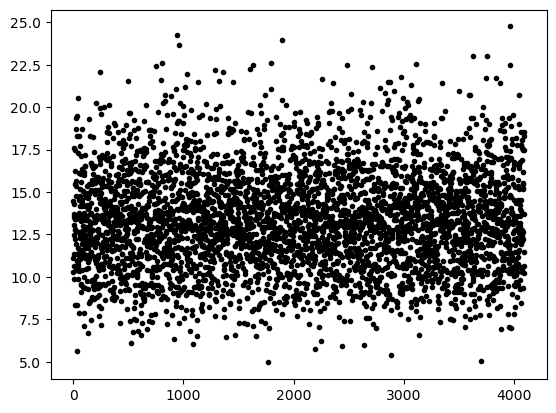

In [20]:
plt.plot(max_intense.vmax10m, ".k")

In [22]:
np.percentile(max_intense.vmax10m, [90])

array([17.165842])

In [23]:
max_intense = huracanpy.calc.apex_vals(
    tcs_usa, tcs_usa.vmax10m * (tcs_usa.basin == "USA").astype(int), tcs_usa.track_id
)
usa_p90_storms = max_intense.hrcn.sel_id(
    max_intense.track_id[
        max_intense.vmax10m > np.percentile(max_intense.vmax10m, [90])
    ]
)

max_intense = huracanpy.calc.apex_vals(
    tcs_japan, tcs_japan.vmax10m * (tcs_japan.basin == "Japan").astype(int), tcs_japan.track_id
)
japan_p90_storms = max_intense.hrcn.sel_id(
    max_intense.track_id[
        max_intense.vmax10m > np.percentile(max_intense.vmax10m, [90])
    ]
)

In [26]:
japan_counts = japan_p90_storms.groupby(
    japan_p90_storms.time.dt.year.astype(str) + 
    japan_p90_storms.ensemble_member.astype(str)
).count()

usa_counts = usa_p90_storms.groupby(
    usa_p90_storms.time.dt.year.astype(str) + 
    usa_p90_storms.ensemble_member.astype(str) 
).count()

In [40]:
counts = dict(
    usa=usa_counts,
    japan=japan_counts,
)

In [43]:
results = {}
for ensemble_member in range(1, 10+1):
    results[ensemble_member] = dict(usa=[], japan=[])
    for year in range(1961, 2023+1):
        for basin in ["usa", "japan"]:
            ds = counts[basin]
            count = ds.lon[ds.group == f"{year}{ensemble_member}"].values

            if len(count) == 1:
                results[ensemble_member][basin].append(count[0])
            else:
                results[ensemble_member][basin].append(0)

In [44]:
results

{1: {'usa': [np.int64(1),
   np.int64(1),
   np.int64(2),
   np.int64(1),
   np.int64(1),
   np.int64(1),
   np.int64(1),
   np.int64(1),
   np.int64(1),
   np.int64(1),
   0,
   0,
   0,
   np.int64(1),
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   np.int64(1),
   np.int64(1),
   np.int64(1),
   0,
   np.int64(1),
   np.int64(1),
   0,
   0,
   np.int64(1),
   np.int64(2),
   0,
   np.int64(1),
   0,
   np.int64(3),
   np.int64(2),
   0,
   0,
   0,
   0,
   np.int64(2),
   np.int64(1),
   0,
   0,
   0,
   0,
   np.int64(1),
   0,
   np.int64(1),
   0,
   0,
   0,
   0,
   0,
   np.int64(1),
   0,
   np.int64(2),
   np.int64(1),
   np.int64(2),
   0,
   0,
   np.int64(1),
   np.int64(1)],
  'japan': [0,
   np.int64(2),
   np.int64(3),
   0,
   np.int64(1),
   np.int64(2),
   np.int64(4),
   np.int64(1),
   np.int64(1),
   np.int64(3),
   0,
   np.int64(1),
   np.int64(1),
   0,
   np.int64(3),
   np.int64(1),
   np.int64(4),
   np.int64(5),
   np.int64(1),
   np.int64(3),
   0,
   np.

In [57]:
bins = np.zeros([7, 7])

for n in range(1, 10+1):
    for usa, japan in zip(results[n]["usa"], results[n]["japan"]):
        bins[usa, japan] += 1
    #plt.figure()
    #for m, basin in enumerate(["usa", "japan"]):
        #plt.bar(range(1961, 2023+1), results[n][basin], color=f"C{m}", label=basin, alpha=0.5)
        
    #plt.legend()

Text(0, 0.5, 'Japan TCs')

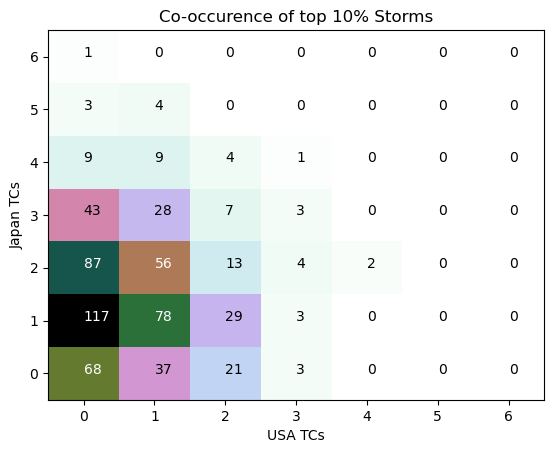

In [83]:
plt.pcolormesh(np.arange(-0.5, 7.5), np.arange(-0.5, 7.5), bins.transpose(), vmin=0, cmap="cubehelix_r")

for n in range(7):
    for m in range(7):
        if bins[n, m] >= 0.5 * bins.max() * 0.75:
            color="w"
        else:
            color="k"
        plt.text(n, m, int(bins[n, m]), color=color)

plt.title("Co-occurence of top 10% Storms")
plt.xlabel("USA TCs")
plt.ylabel("Japan TCs")
#plt.xlim(-0.5, 4.5)


In [85]:
bins.sum()

np.float64(630.0)